# Testing out PHE (Partially Homomorphic Encryption) with the Deepface Framework

In [1]:
# importing necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from lightphe import LightPHE
from deepface import DeepFace

import pytest

In [2]:
os.makedirs("test_images", exist_ok=True)
os.makedirs("keys", exist_ok=True)

# Define paths for key files
private_key_path = "keys/private_key.txt"
public_key_path = "keys/public_key.txt"


In [9]:
# Part 1: Setup the on-prem side (client with private key)
print("Setting up client side with private key...")

# Initialize the homomorphic cryptosystem
example_cs = LightPHE(algorithm_name="Paillier", precision=19)

# Export the keys, the client has two set of keys: private and public
if keys := os.path.exists(private_key_path) and os.path.exists(public_key_path):
    print("Keys already exist, skipping export.")
    client_cs = LightPHE(algorithm_name="Paillier", precision=19, key_file=private_key_path)
    server_cs = LightPHE(algorithm_name="Paillier", precision=19, key_file=public_key_path)
else: 
    example_cs.export_keys(private_key_path, public=False)
    example_cs.export_keys(public_key_path, public=True)

    client_cs = LightPHE(algorithm_name="Paillier", precision=19, key_file=private_key_path)
    server_cs = LightPHE(algorithm_name="Paillier", precision=19, key_file=public_key_path)




Setting up client side with private key...
Keys already exist, skipping export.
25-07-04 15:05:24 - private-public key pair is restored from keys/private_key.txt
25-07-04 15:05:24 - public key is restored from keys/public_key.txt


In [10]:
# Part 2: Test Basic Homomorphic operations: 
print("\nTesting basic homomorphic operations...")

# define certain plain texts
m1 = 10000
m2 = 500

c1 = client_cs.encrypt(m1)
c2 = client_cs.encrypt(m2)

# this would be the homomorphic addition, since we are adding two encrypted plaintexts together
c3 = c1 + c2

# homomorphic scalar multiplication
k = 3
c4 = k * c1




Testing basic homomorphic operations...


In [10]:
# decrypt and verify the results here 
print(f"Original values: {m1} and {m2}")
print(f"Decrypted addition: {client_cs.decrypt(c3)}")
print(f"Expected addition: {m1 + m2}")
print(f"Decrypted scalar multiplication: {client_cs.decrypt(c4)}")
print(f"Expected scalar multiplication: {k * m1}")
assert client_cs.decrypt(c3) == m1 + m2, "Homomorphic addition failed!"
assert client_cs.decrypt(c4) == k * m1, "Homomorphic scalar multiplication failed!"


Original values: 10000 and 500
Decrypted addition: 10500
Expected addition: 10500
Decrypted scalar multiplication: 30000
Expected scalar multiplication: 30000


 ### This means it is possible to multiply the corresponding dimension values of the encrypted vector from the client side with the plain vector from the cloud side element-wisely. The result will be a set of encrypted values for each dimension. Finally, you can sum the encrypted dimensions of this new encrypted vector – because we adopted additively homomorphic encryption algorithm – which gives you the encrypted cosine similarity. This approach allows you to compute cosine similarity securely while maintaining privacy.

 ### LightPHE supports several additively homomorphic encryption algorithms, including Paillier, Damgard-Jurik, Benaloh, Naccache-Stern, Okamoto-Uchiyama, Exponential ElGamal and Elliptic Curve ElGamal. However, Benaloh and Naccache-Stern are considered experimental, as they encounter issues when generating keys for longer bit lengths. Additionally, Exponential ElGamal relies on solving the discrete logarithm problem, while Elliptic Curve ElGamal requires solving the elliptic curve discrete logarithm problem during decryption. Due to these computational challenges, both are also classified as experimental and are not suitable for practical applications. In summary, to encrypt vector embeddings for encrypted vector similarity search, you should use Paillier, Damgard-Jurik, or Okamoto-Uchiyama, as they are the most practical choices.


Processing face embeddings...


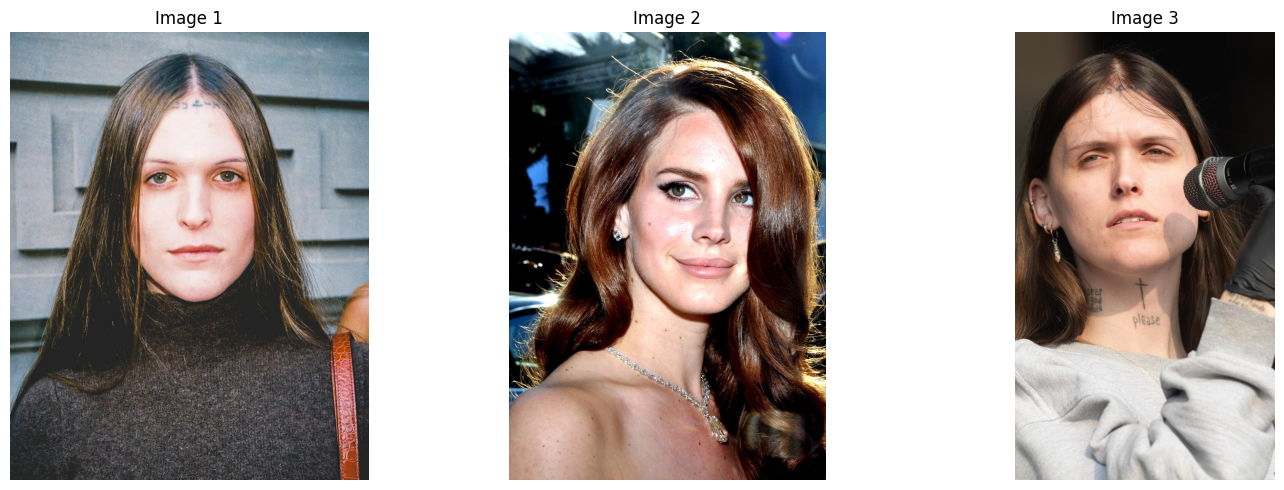

In [11]:
# Part 3: Testing with face embeddings

print("\nProcessing face embeddings...")
def download_sample_images():
    import requests
    
    image_urls = {
        "img1.jpg": "https://scontent.fdad3-1.fna.fbcdn.net/v/t51.75761-15/472904288_18479691505008747_5108622755100274801_n.jpg?stp=dst-jpg_s1080x2048_tt6&_nc_cat=108&ccb=1-7&_nc_sid=127cfc&_nc_ohc=CK5R9XS6rcQQ7kNvwH6nP__&_nc_oc=AdlJRamIM99qE_yRF4sbD8pdEVbmZNIDCUIQbToQHNauRiu932tzSHqpULJvYjqeyuI&_nc_zt=23&_nc_ht=scontent.fdad3-1.fna&_nc_gid=CMqsoC0d4vvPpm5Sa73x-w&oh=00_AfMKoRMzuVw5BbU9A_SGbJCs2SUDe5OsKw7uCCbhEuM04Q&oe=6866DF80",
        "img2.jpg": "https://upload.wikimedia.org/wikipedia/commons/7/71/Lana_Del_Rey_Cannes_2012.jpg",
        "img3.jpg": "https://seatgeekimages.com/performers-landscape/ethel-cain-2c11be/798453/1100x1900.jpg?auto=webp&width=3840&quality=75"
    }
    
    for filename, url in image_urls.items():
        filepath = os.path.join("test_images", filename)
        if not os.path.exists(filepath):
            print(f"Downloading {filename}...")
            response = requests.get(url)
            with open(filepath, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded {filename}")

download_sample_images()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, img_file in enumerate(["img1.jpg", "img2.jpg", "img3.jpg"]):
    img_path = os.path.join("test_images", img_file)
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


In [12]:
# generating face bedddings
try: 
    ethel1_embedding = DeepFace.represent(os.path.join("test_images", "img1.jpg"), model_name="VGG-Face",  detector_backend="yunet")[0]["embedding"]
    ethel2_embedding = DeepFace.represent(os.path.join("test_images", "img3.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    lana_embedding = DeepFace.represent(os.path.join("test_images", "img2.jpg"), model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
    print(f"Embedding shape: {np.array(ethel1_embedding).shape}")

    print("Encrypting face embeddings...")
    ethel1_encrypted = client_cs.encrypt(ethel1_embedding)
    ethel2_encrypted = client_cs.encrypt(ethel2_embedding)
    lana_encrypted = client_cs.encrypt(lana_embedding)

    print("Face embeddings encrypted successfully.")


    # Test whether server can decrypt the embeddings
    try:
        server_cs.decrypt(ethel1_encrypted)
        print("ERROR: Cloud should not be able to decrypt!")
    except ValueError as e:
        print(f"As expected, the server cannot decrypt the encrypted embeddings: {str(e)}")

    
except Exception as e: 
    print("Error in generating face embeddings. Ensure DeepFace is installed and configured correctly.")


Embedding shape: (4096,)
Encrypting face embeddings...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1902.47it/s]


Face embeddings encrypted successfully.
As expected, the server cannot decrypt the encrypted embeddings: You must have private key to perform decryption


In [13]:

    # Part 5: Perform similarity calculations

print("\nPerforming similarity calculations...")
# Compute similarities between encrypted and plain embeddings
encrypted_sim_e1_e2 = ethel1_encrypted @ ethel2_embedding

# test 2: Ethel vs Lana (should not match)
encrypted_sim_e1_l = ethel1_encrypted @ lana_embedding




Performing similarity calculations...


In [16]:
# Decrypt the results on the client/on-prem side
print("\nDecrypting results on the client side...")
sim_e1_e2 = client_cs.decrypt(encrypted_sim_e1_e2)[0]
sim_e1_l = client_cs.decrypt(encrypted_sim_e1_l)[0]

#calculate expected similarities for
expected_sim_e1_e2 = sum(x * y for x, y in zip(ethel1_embedding, ethel2_embedding))
expected_sim_e1_l = sum(x * y for x, y in zip(ethel1_embedding, lana_embedding))

print(f"Ethel vs Ethel (encrypted): {sim_e1_e2}")
print(f"Ethel vs Ethel (plaintext): {expected_sim_e1_e2}")
print(f"Error: {abs(sim_e1_e2 - expected_sim_e1_e2)}")

print(f"Ethel vs Lana (encrypted): {sim_e1_l}")
print(f"Ethel vs Lana (plaintext): {expected_sim_e1_l}")
print(f"Error: {abs(sim_e1_l - expected_sim_e1_l)}")


Decrypting results on the client side...
Ethel vs Ethel (encrypted): 0.4012305442478115
Ethel vs Ethel (plaintext): 0.4012305442478117
Error: 1.6653345369377348e-16
Ethel vs Lana (encrypted): 0.0739515581700058
Ethel vs Lana (plaintext): 0.07395155817000582
Error: 1.3877787807814457e-17


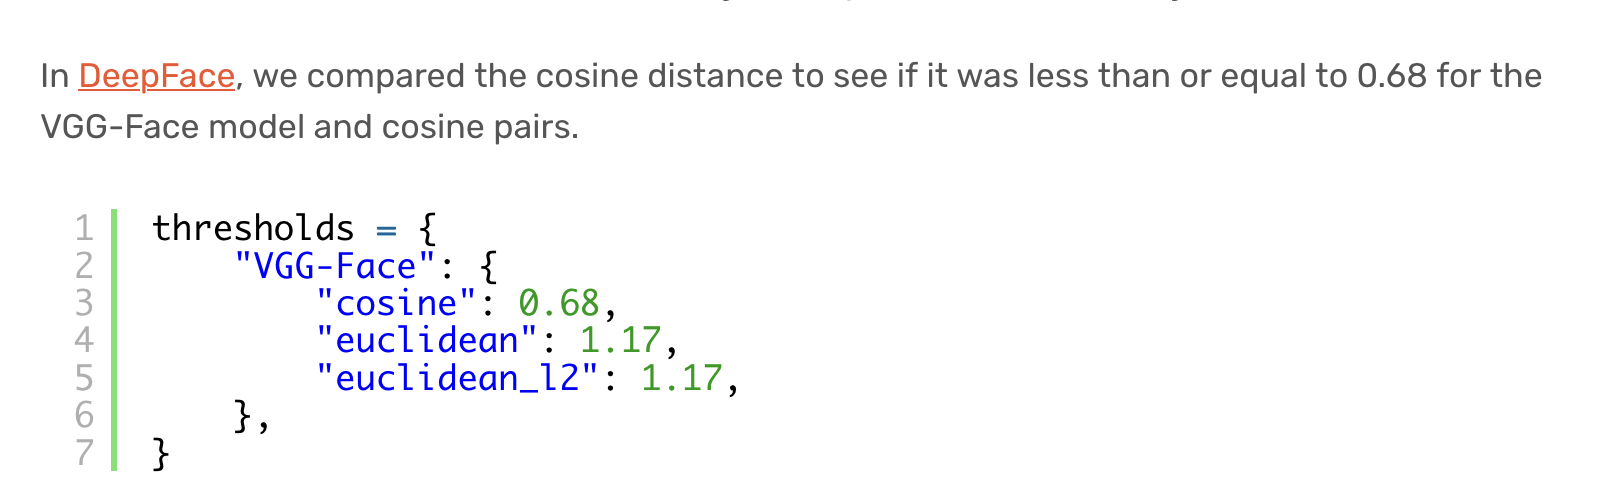

In [15]:
threshold = 0.32 # 1 - 0.68 from Deepface

print(f"Threshold for matching: {threshold}")

print(f"Ethel and Ethel: {'MATCH' if sim_e1_e2 >= threshold else 'NO MATCH'} (score: {sim_e1_e2:.4f})")
print(f"Ethel vs Lana: {'MATCH' if sim_e1_l >= threshold else 'NO MATCH'} (score: {sim_e1_l:.4f})")


Threshold for matching: 0.32
Ethel and Ethel: MATCH (score: 0.4012)
Ethel vs Lana: NO MATCH (score: 0.0740)


This is a good thing lol, they match

In [16]:
models = ["Facenet", "VGG-Face", "Facenet512", "ArcFace", "SFace"]
import time
import pandas as pd
import seaborn as sns
from tqdm import tqdm

extraction_times = {}
encryption_times = {}
similarity_times = {}
total_times = {}
embedding_sizes = {}

test_image_path = os.path.join("test_images", "img1.jpg")

print("Testing extraction, encryption, and similarity computation times across models...")

for model_name in tqdm(models):
    try:
        # Time embedding extraction
        start_time = time.time()
        embedding = DeepFace.represent(test_image_path, model_name=model_name)[0]["embedding"]
        extraction_end = time.time()
        extraction_time = extraction_end - start_time
        
        # Record embedding size
        embedding_size = len(embedding)
        embedding_sizes[model_name] = embedding_size
        
        # Time encryption
        start_time = time.time()
        encrypted_embedding = client_cs.encrypt(embedding)
        encryption_end = time.time()
        encryption_time = encryption_end - start_time
        
        # Create a second embedding for similarity testing, ethel cain 1 vs ethel cain 2
        embedding2 = DeepFace.represent(os.path.join("test_images", "img3.jpg"), model_name=model_name)[0]["embedding"]
        
        # Time similarity computation (dot product)
        start_time = time.time()
        encrypted_similarity = encrypted_embedding @ embedding2
        similarity_time = time.time() - start_time
        
        # Store timing results
        extraction_times[model_name] = extraction_time
        encryption_times[model_name] = encryption_time
        similarity_times[model_name] = similarity_time
        total_times[model_name] = extraction_time + encryption_time + similarity_time
        
        print(f"\n{model_name} Results:")
        print(f"  - Embedding size: {embedding_size}")
        print(f"  - Extraction time: {extraction_time:.4f} seconds")
        print(f"  - Encryption time: {encryption_time:.4f} seconds")
        print(f"  - Similarity computation time: {similarity_time:.4f} seconds")
        print(f"  - Total time: {total_times[model_name]:.4f} seconds")
        
    except Exception as e:
        print(f"Error testing {model_name}: {str(e)}")

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Model': list(extraction_times.keys()),
    'Embedding Size': [embedding_sizes.get(model, 0) for model in extraction_times.keys()],
    'Extraction Time (s)': list(extraction_times.values()),
    'Encryption Time (s)': list(encryption_times.values()),
    'Similarity Time (s)': list(similarity_times.values()),
    'Total Time (s)': list(total_times.values())
})

df = df.sort_values('Total Time (s)')

plt.figure(figsize=(14, 10))

# Plot 1: Stacked bar chart of timing components
plt.subplot(2, 1, 1)
df_plot = df.set_index('Model')
df_plot[['Extraction Time (s)', 'Encryption Time (s)', 'Similarity Time (s)']].plot(
    kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Processing Time Breakdown by Model')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Scatter plot of encryption time vs embedding size
plt.subplot(2, 1, 2)
plt.scatter(df['Embedding Size'], df['Encryption Time (s)'], s=100, alpha=0.7)
for i, model in enumerate(df['Model']):
    plt.annotate(model, 
                 (df['Embedding Size'].iloc[i], df['Encryption Time (s)'].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.title('Encryption Time vs Embedding Size')
plt.xlabel('Embedding Size (dimensions)')
plt.ylabel('Encryption Time (seconds)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Create a detailed performance table
print("\nPerformance Summary Table:")
print(df.to_string(index=False))


df.to_csv('model_encryption_performance.csv', index=False)
print("\nResults saved to 'model_encryption_performance.csv'")

Testing extraction, encryption, and similarity computation times across models...


Encrypting tensors:  77%|███████▋  | 99/128 [00:01<00:00, 64.65it/s] Process SpawnPoolWorker-64:
Process SpawnPoolWorker-58:
Process SpawnPoolWorker-53:
Process SpawnPoolWorker-50:
Process SpawnPoolWorker-54:
Process SpawnPoolWorker-51:
Process SpawnPoolWorker-52:
Process SpawnPoolWorker-57:

  0%|          | 0/5 [00:04<?, ?it/s]Process SpawnPoolWorker-55:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ritherthemuncher/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/ritherthemuncher/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/ritherthemuncher/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/ritherthemuncher/anaconda3/lib/python3.11

KeyboardInterrupt: 

Initializing webcam...
Capturing in 3 seconds... Look at the camera
3...
2...
1...
Smile!
Image saved to test_images/webcam_capture.jpg

Processing your face image...


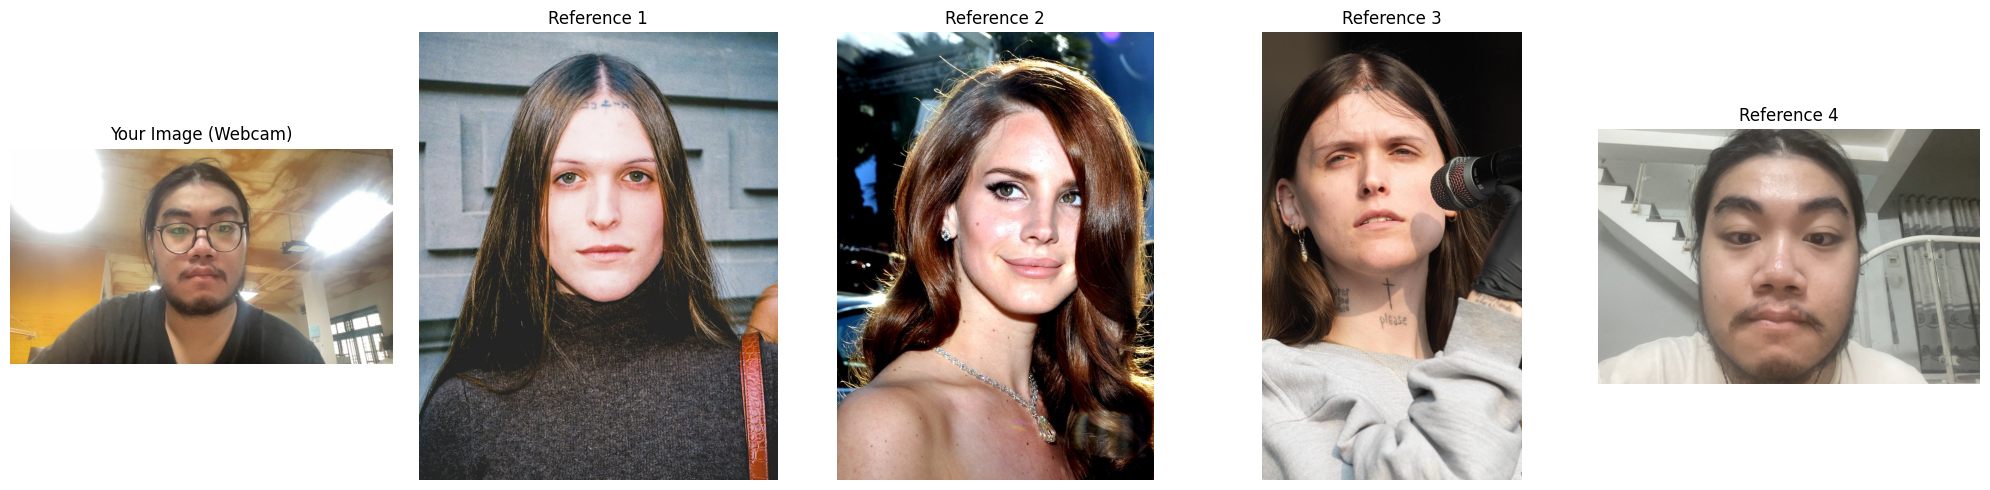


Extracting face embeddings...


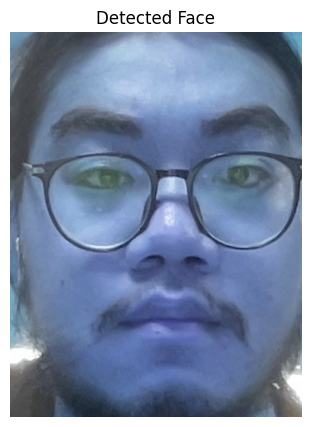

Face embedding extracted. Shape: (4096,)

Encrypting your face embedding...


Encrypting tensors: 100%|██████████| 4096/4096 [00:02<00:00, 1588.05it/s]


Encryption complete!

Comparing with reference faces...
Similarity with Ethel 1: 0.0575
Similarity with Lana Del Rey: 0.0346
Similarity with Ethel 2: 0.0787
Similarity with Rither: 0.4729

Using threshold: 0.32

Match Results:
You and Ethel 1: NO MATCH (score: 0.0575)
You and Lana Del Rey: NO MATCH (score: 0.0346)
You and Ethel 2: NO MATCH (score: 0.0787)
You and Rither: MATCH (score: 0.4729)


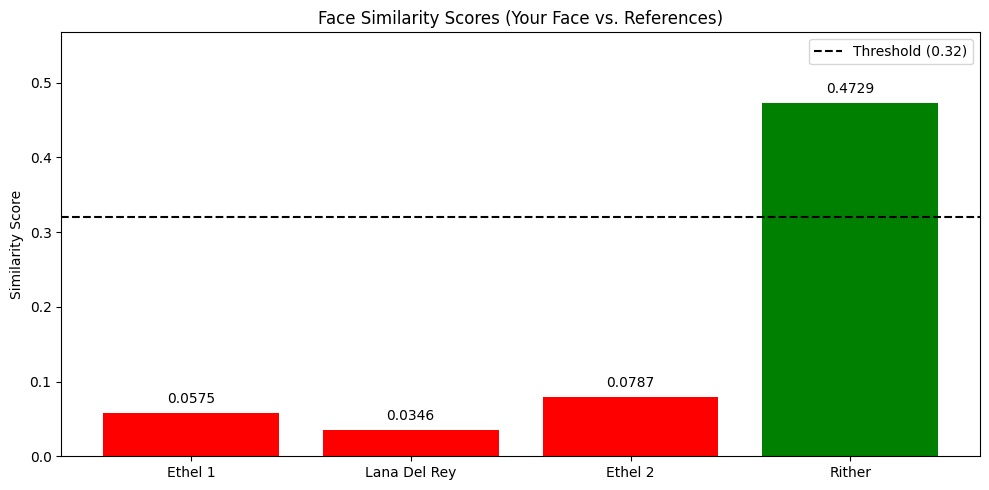

In [ ]:
# Part 3B: Using webcam for face embedding and PHE testing
import cv2
import time
import os
from tqdm import tqdm
import threading

def capture_from_webcam():
    """Capture an image from webcam and save it to test_images folder without text overlay"""
    # Initialize webcam
    print("Initializing webcam...")
    cap = cv2.VideoCapture(0)  
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None
    
    # Create preview window
    cv2.namedWindow("Webcam Preview", cv2.WINDOW_NORMAL)
    
    # Wait for camera to initialize
    time.sleep(1)
    
    countdown_seconds = 3
    captured_frame = None
    
    print(f"Capturing in {countdown_seconds} seconds... Look at the camera")
    
    # Countdown loop
    for i in range(countdown_seconds, 0, -1):
        print(f"{i}...")
        
        # Capture frames during countdown
        for _ in range(10):  # Show multiple frames during each countdown second
            ret, frame = cap.read()
            if not ret:
                print("Error: Failed to capture frame.")
                cap.release()
                cv2.destroyAllWindows()
                return None
                
            # Display countdown on frame - but don't modify the original frame
            display_frame = frame.copy()
            cv2.putText(display_frame, str(i), (display_frame.shape[1]//2 - 50, display_frame.shape[0]//2 + 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 4)
            cv2.imshow("Webcam Preview", display_frame)
            cv2.waitKey(100)  # Small delay
    
    # Capture the final frame
    print("Smile!")
    ret, frame = cap.read()
    
    if ret:
        captured_frame = frame.copy()  # Store the clean frame without any text
        
        # Show "Captured!" message on display frame only
        display_frame = frame.copy()
        cv2.putText(display_frame, "Captured!", (display_frame.shape[1]//2 - 100, display_frame.shape[0]//2 + 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 2)
        cv2.imshow("Webcam Preview", display_frame)
        cv2.waitKey(1000)  # Show for 1 second
        
        # Save the clean image without any text
        img_path = os.path.join("test_images", "webcam_capture.jpg")
        cv2.imwrite(img_path, captured_frame)
        print(f"Image saved to {img_path}")
    else:
        print("Error: Failed to capture frame.")
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    
    return img_path if captured_frame is not None else None


# Capture image from webcam
webcam_img_path = capture_from_webcam()

if webcam_img_path is not None:
    print("\nProcessing your face image...")
    
    # Get reference images for comparison
    reference_images = ["img1.jpg", "img2.jpg", "img3.jpg", "selfie.jpg"]
    
    # Ensure reference images exist
    for img_file in reference_images:
        if not os.path.exists(os.path.join("test_images", img_file)):
            print(f"Reference image {img_file} not found. Running download function...")
            download_sample_images()
            break
    
    # Display your image alongside reference images
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    # Your webcam image
    img = Image.open(webcam_img_path)
    axes[0].imshow(img)
    axes[0].set_title("Your Image (Webcam)")
    axes[0].axis('off')
    
    # Reference images
    for i, img_file in enumerate(reference_images):
        img_path = os.path.join("test_images", img_file)
        img = Image.open(img_path)
        axes[i+1].imshow(img)
        axes[i+1].set_title(f"Reference {i+1}")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    try:
        print("\nExtracting face embeddings...")
        
        webcam_faces = DeepFace.extract_faces(webcam_img_path, detector_backend="yunet", enforce_detection=True)
        
        if len(webcam_faces) == 0:
            print("No face detected in your webcam image!")
        else:
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            face_img = webcam_faces[0]['face']
            face_img_uint8 = (face_img * 255).astype("uint8") if face_img.dtype != "uint8" else face_img
            face_img_rgb = cv2.cvtColor(face_img_uint8, cv2.COLOR_BGR2RGB)
            ax.imshow(face_img_rgb)
            ax.set_title("Detected Face")
            ax.axis('off')
            plt.show()
        

        my_embedding = DeepFace.represent(webcam_img_path, model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]

        ref_embeddings = []
        ref_names = ["Ethel 1", "Lana Del Rey", "Ethel 2", "Rither"]
        
        for i, img_file in enumerate(reference_images):
            img_path = os.path.join("test_images", img_file)
            embedding = DeepFace.represent(img_path, model_name="VGG-Face", detector_backend="yunet")[0]["embedding"]
            ref_embeddings.append((ref_names[i], embedding))
        
        print(f"Face embedding extracted. Shape: {np.array(my_embedding).shape}")
        
        print("\nEncrypting your face embedding...")
        my_encrypted = server_cs.encrypt(my_embedding)
        print("Encryption complete!")
        
        print("\nComparing with reference faces...")
        results = []
        
        for name, ref_embedding in ref_embeddings:
            # Convert numpy array to list if necessary
            if isinstance(ref_embedding, np.ndarray):
                ref_embedding_list = ref_embedding.tolist()
            else:
                ref_embedding_list = ref_embedding
            
            # Compute encrypted similarity with proper types
            encrypted_sim = my_encrypted @ ref_embedding_list
            
            # Decrypt the result
            decrypted_sim = client_cs.decrypt(encrypted_sim)[0]
            
            # Calculate plaintext similarity for verification
            expected_sim = sum(x * y for x, y in zip(my_embedding, ref_embedding))
            
            # Store results
            results.append({
                "name": name,
                "encrypted_similarity": decrypted_sim,
                "plaintext_similarity": expected_sim,
                "error": abs(decrypted_sim - expected_sim)
            })
            
            print(f"Similarity with {name}: {decrypted_sim:.4f}")        
        # Show match results
        threshold = 0.32  # 1 - 0.68 from DeepFace
        
        print(f"\nUsing threshold: {threshold}")
        print("\nMatch Results:")
        
        for result in results:
            match_status = "MATCH" if result["encrypted_similarity"] >= threshold else "NO MATCH"
            print(f"You and {result['name']}: {match_status} (score: {result['encrypted_similarity']:.4f})")
        
        # Visualize results
        names = [r["name"] for r in results]
        scores = [r["encrypted_similarity"] for r in results]
        
        plt.figure(figsize=(10, 5))
        bars = plt.bar(names, scores, color=['green' if s >= threshold else 'red' for s in scores])
        plt.axhline(y=threshold, color='black', linestyle='--', label=f'Threshold ({threshold})')
        
        plt.title('Face Similarity Scores (Your Face vs. References)')
        plt.ylabel('Similarity Score')
        plt.ylim(0, max(scores) * 1.2)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.4f}', ha='center', va='bottom')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error processing face embedding: {str(e)}")

else:
    print("Failed to capture image from webcam.")